# Effect of Class Time on Grades, For Math Classes

Alexander Bailey, Kayli Leung

# Methodology
We will perform a two-tail, two-sample t-test on the data. Using [Kaggle's UW Madison Grade's Database](https://www.kaggle.com/Madgrades/uw-madison-courses#schedules.csv).

## Question

Is a significant difference in the percentage of A's given based on whether a class starts before noon or after noon, given that the class is a math class. 

## Hypotheses
We select an alpha value of 0.05.

Null Hypothesis: There is no significant difference in the mean percentage of A's in the morning classes and afternoon math classes.

Alternate Hypothesis: There is a significant difference in the mean percentage of A's in the morning and afternoon math classes.

Class start and end time is listed in minutes from midnight.

In [2]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')
import numpy as np
import scipy.stats as stats

In [3]:
conn = psycopg2.connect("host=localhost,dbname=postgres,user=postgres")

cur = conn.cursor()

In [4]:
group_and_as = """
SELECT 
  grade.a_count
, grade.ab_count
, grade.b_count
, grade.bc_count
, grade.c_count
, grade.d_count
, grade.f_count
, sched.start_time
, sect.section_type
, grade.course_offering_uuid
, grade.section_number
, sub.name
FROM 
  sections sect
INNER JOIN 
  schedules sched 
ON 
  sched.uuid = sect.schedule_uuid
INNER JOIN 
  grade_distributions grade 
ON 
  sect.number = grade.section_number
INNER JOIN
  subject_memberships sub_m
ON
  sub_m.course_offering_uuid = sect.course_offering_uuid
INNER JOIN
  subjects sub
ON
  sub.code = sub_m.subject_code
AND 
  sect.course_offering_uuid = grade.course_offering_uuid
WHERE
  sub.name = 'Mathematics';
"""

In [5]:
cur.execute(group_and_as)
df = pd.DataFrame(cur.fetchall())
df.columns = [i[0] for i in cur.description]
df['total_count'] = (df['a_count'] + df['ab_count'] + df['b_count'] + df['bc_count'] 
                     + df['c_count'] + df['d_count'] + df['f_count'])
df.head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,start_time,section_type,course_offering_uuid,section_number,name,total_count
0,2,1,1,2,2,2,1,660,LEC,7f8ded97-695f-326e-97f1-a62293258178,1,Mathematics,11
1,2,1,4,1,3,1,0,800,LEC,7f8ded97-695f-326e-97f1-a62293258178,2,Mathematics,12
2,2,2,8,2,2,0,1,595,LEC,c9a679c5-8852-3cf7-94b2-917f5e749f58,1,Mathematics,17
3,3,1,0,4,5,0,2,800,LEC,c9a679c5-8852-3cf7-94b2-917f5e749f58,2,Mathematics,15
4,4,5,5,2,5,5,2,595,LEC,5144f795-9d64-3e39-949c-30b051952990,1,Mathematics,28


In [6]:
df.sort_values(by='start_time').head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,start_time,section_type,course_offering_uuid,section_number,name,total_count
2690,0,0,0,0,0,0,0,-1,IND,e4714b36-e7b3-3a9e-9570-c137f43a0893,10,Mathematics,0
2896,0,0,0,0,0,0,0,-1,IND,7e7dd109-ed5c-32b9-9b96-60ab1860d4fa,63,Mathematics,0
2895,0,0,0,0,0,0,0,-1,IND,7e7dd109-ed5c-32b9-9b96-60ab1860d4fa,62,Mathematics,0
2278,0,0,0,0,0,0,0,-1,IND,39227c54-f3c9-3459-adcb-931e37a53bfb,166,Mathematics,0
2894,0,0,0,0,0,0,0,-1,IND,7e7dd109-ed5c-32b9-9b96-60ab1860d4fa,157,Mathematics,0


In [7]:
df.loc[df['start_time'] != -1, 'section_type'].value_counts()

LEC    2843
SEM     112
DIS      46
Name: section_type, dtype: int64

All the independent studies are -1. As all these values are no use to our test (because we are interested in start time) we will drop all start_times of -1. We will also cut of irregular times (classes that start before 6AM) because these are potentially errors during input.

In [8]:
df = df[df['start_time'] >= 360]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3001 entries, 0 to 3534
Data columns (total 13 columns):
a_count                 3001 non-null int64
ab_count                3001 non-null int64
b_count                 3001 non-null int64
bc_count                3001 non-null int64
c_count                 3001 non-null int64
d_count                 3001 non-null int64
f_count                 3001 non-null int64
start_time              3001 non-null int64
section_type            3001 non-null object
course_offering_uuid    3001 non-null object
section_number          3001 non-null int64
name                    3001 non-null object
total_count             3001 non-null int64
dtypes: int64(10), object(3)
memory usage: 328.2+ KB


In [9]:
df.sort_values(by='total_count').head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,start_time,section_type,course_offering_uuid,section_number,name,total_count
2621,0,0,0,0,0,0,0,930,SEM,bf19f884-af31-337a-8c09-b22f589d162f,1,Mathematics,0
2632,0,0,0,0,0,0,0,800,SEM,a7945a4f-4567-3259-8d19-9855cffee997,2,Mathematics,0
3467,0,0,0,0,0,0,0,660,LEC,bf2dc418-3acc-3d9a-bbb6-7387422ddddd,1,Mathematics,0
2631,0,0,0,0,0,0,0,870,SEM,a7945a4f-4567-3259-8d19-9855cffee997,1,Mathematics,0
2627,0,0,0,0,0,0,0,865,SEM,27b7a165-e6de-3a31-9b5d-43ede2589f86,2,Mathematics,0


There are still a number of classes that have no students. We want to drop these as it is not reflective of our study.

In [10]:
df = df[df['total_count'] != 0]

In [12]:
df['total_count'].value_counts().head()

22    125
19    117
20    117
21    109
17     98
Name: total_count, dtype: int64

In [13]:
df2 = df.copy()

In [14]:
df2['ratio_of_as'] = df['a_count'] / df['total_count']

In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2869 entries, 0 to 3534
Data columns (total 14 columns):
a_count                 2869 non-null int64
ab_count                2869 non-null int64
b_count                 2869 non-null int64
bc_count                2869 non-null int64
c_count                 2869 non-null int64
d_count                 2869 non-null int64
f_count                 2869 non-null int64
start_time              2869 non-null int64
section_type            2869 non-null object
course_offering_uuid    2869 non-null object
section_number          2869 non-null int64
name                    2869 non-null object
total_count             2869 non-null int64
ratio_of_as             2869 non-null float64
dtypes: float64(1), int64(10), object(3)
memory usage: 336.2+ KB


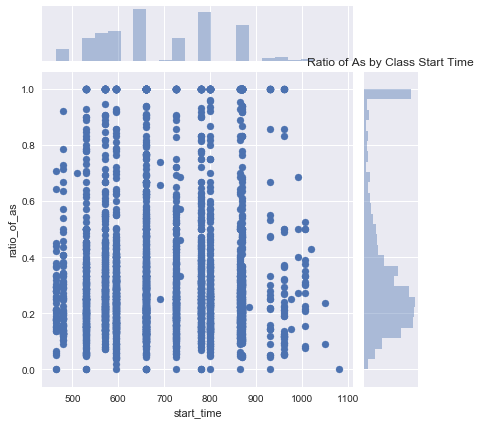

In [27]:
sns.jointplot('start_time', 'ratio_of_as',df2)
plt.title('Ratio of As by Class Start Time')
plt.show();

In [74]:
df2.drop_duplicates(inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2707 entries, 0 to 3534
Data columns (total 14 columns):
a_count                 2707 non-null int64
ab_count                2707 non-null int64
b_count                 2707 non-null int64
bc_count                2707 non-null int64
c_count                 2707 non-null int64
d_count                 2707 non-null int64
f_count                 2707 non-null int64
start_time              2707 non-null int64
section_type            2707 non-null object
course_offering_uuid    2707 non-null object
section_number          2707 non-null int64
name                    2707 non-null object
total_count             2707 non-null int64
ratio_of_as             2707 non-null float64
dtypes: float64(1), int64(10), object(3)
memory usage: 317.2+ KB


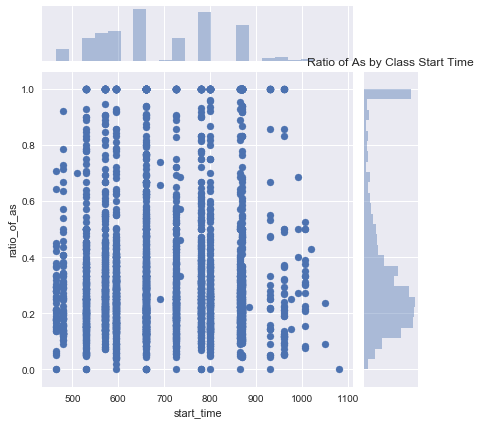

In [21]:
sns.jointplot('start_time', 'ratio_of_as',df2)
plt.title('Ratio of As by Class Start Time')
plt.show();

In [76]:
df2['section_type'].value_counts()

LEC    2629
DIS      46
SEM      32
Name: section_type, dtype: int64

In [23]:
morning_df = df2.loc[df2['start_time'] < 720]
afternoon_df = df2.loc[df2['start_time'] >= 720]

In [81]:
morning_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1493 entries, 0 to 3532
Data columns (total 14 columns):
a_count                 1493 non-null int64
ab_count                1493 non-null int64
b_count                 1493 non-null int64
bc_count                1493 non-null int64
c_count                 1493 non-null int64
d_count                 1493 non-null int64
f_count                 1493 non-null int64
start_time              1493 non-null int64
section_type            1493 non-null object
course_offering_uuid    1493 non-null object
section_number          1493 non-null int64
name                    1493 non-null object
total_count             1493 non-null int64
ratio_of_as             1493 non-null float64
dtypes: float64(1), int64(10), object(3)
memory usage: 175.0+ KB


In [82]:
afternoon_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1214 entries, 1 to 3534
Data columns (total 14 columns):
a_count                 1214 non-null int64
ab_count                1214 non-null int64
b_count                 1214 non-null int64
bc_count                1214 non-null int64
c_count                 1214 non-null int64
d_count                 1214 non-null int64
f_count                 1214 non-null int64
start_time              1214 non-null int64
section_type            1214 non-null object
course_offering_uuid    1214 non-null object
section_number          1214 non-null int64
name                    1214 non-null object
total_count             1214 non-null int64
ratio_of_as             1214 non-null float64
dtypes: float64(1), int64(10), object(3)
memory usage: 142.3+ KB


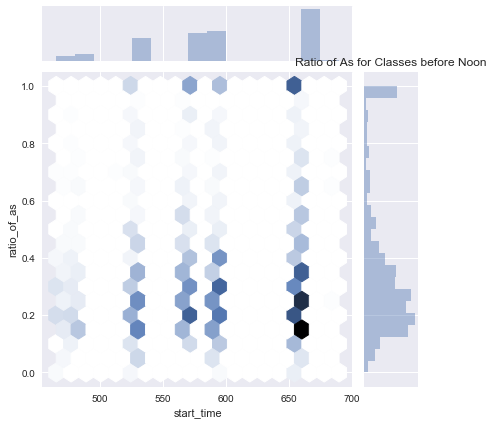

In [25]:
sns.jointplot('start_time', 'ratio_of_as',morning_df,kind='hex')
plt.title('Ratio of As for Classes before Noon')
plt.show();

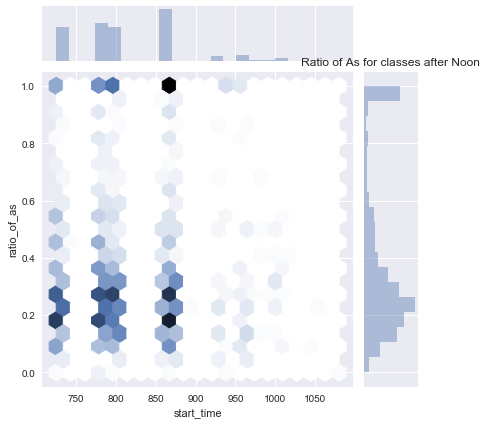

In [26]:
sns.jointplot('start_time', 'ratio_of_as',afternoon_df,kind='hex')
plt.title('Ratio of As for classes after Noon')
plt.show();

# Determine Sample Size

In [88]:
moe = 0.1
z = 1.96 # z value for alpha 0.05
morn_var = np.var(morning_df['ratio_of_as'])
morn_n = len(morning_df['ratio_of_as'])
aft_var = np.var(afternoon_df['ratio_of_as'])
aft_n = len(afternoon_df['ratio_of_as'])

num = (morn_n - 1) * morn_var + (aft_n - 1) * aft_var
den = morn_n + aft_n - 2
pooled_std = np.sqrt(num/den)

In [89]:
n = 2 * (z * pooled_std / moe)**2
n

56.79518373077116

We will use samples from morning and afternoon of size 68.

In [97]:
np.random.seed(20)

morning = morning_df['ratio_of_as']
afternoon = afternoon_df['ratio_of_as']

morning_sample = np.random.choice(morning, size=57)
afternoon_sample = np.random.choice(afternoon, size=57)

In [98]:
stats.ttest_ind(morning_sample, afternoon_sample)

Ttest_indResult(statistic=-0.8321751863485252, pvalue=0.40708093502863274)

Our p-value is about 0.407 which is greater than our alpha of 0.05. This means that we cannot reject the null hypothesis. Even when we look only at math classes we still cannot say that there is a statistical difference in the ratio of A's of a class depending on if the class is before or after noon. 

If we want to improve our schedules to increase the percentage of A's we will need to look at other factors.